# Notebook sulla coregistrazione delle immagini
All'interno del seguente notebook sono riportate le tecniche e le spiegazioni su esse utilizzate per effetturare la coregistrazione delle immagini, passaggio preliminre alla creazione su sub images che risulteranno essere il nostro dataset di addestramento e test

### 1. Pacchetti necessari

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

### Opzionale: funzioni custom per la visualizzazione

In [15]:
STD_FIGSIZE = (20, 20)

In [20]:
def show_side_images(image_1, title_1, image_2, title_2, cmap='gray', figsize=STD_FIGSIZE):
    figure, subplots = plt.subplots(1, 2, figsize=figsize)
    figure.subplots_adjust(wspace=0.01)
    subplots[0].set_title(title_1)
    subplots[0].axis('off')
    subplots[0].imshow(image_1, cmap=cmap)
    subplots[1].set_title(title_2)
    subplots[1].axis('off')
    subplots[1].imshow(image_2, cmap=cmap)

In [21]:
def show_side_hist(image_1, title_1, image_2, title_2, cmap='gray', figsize=STD_FIGSIZE):
    figure, subplots = plt.subplots(1, 2, figsize=figsize)

    subplots[0].set_title(title_1)
    # conversione vettore 1D
    subplots[0].hist(image_1.ravel(), bins=256, range=(0, 256), color='black', alpha=0.75)

    subplots[1].set_title(title_2)
    subplots[1].hist(image_2.ravel(), bins=256, range=(0, 256), color='blue', alpha=0.75)

    plt.tight_layout()
    plt.show()

### 2. Apertura immagini

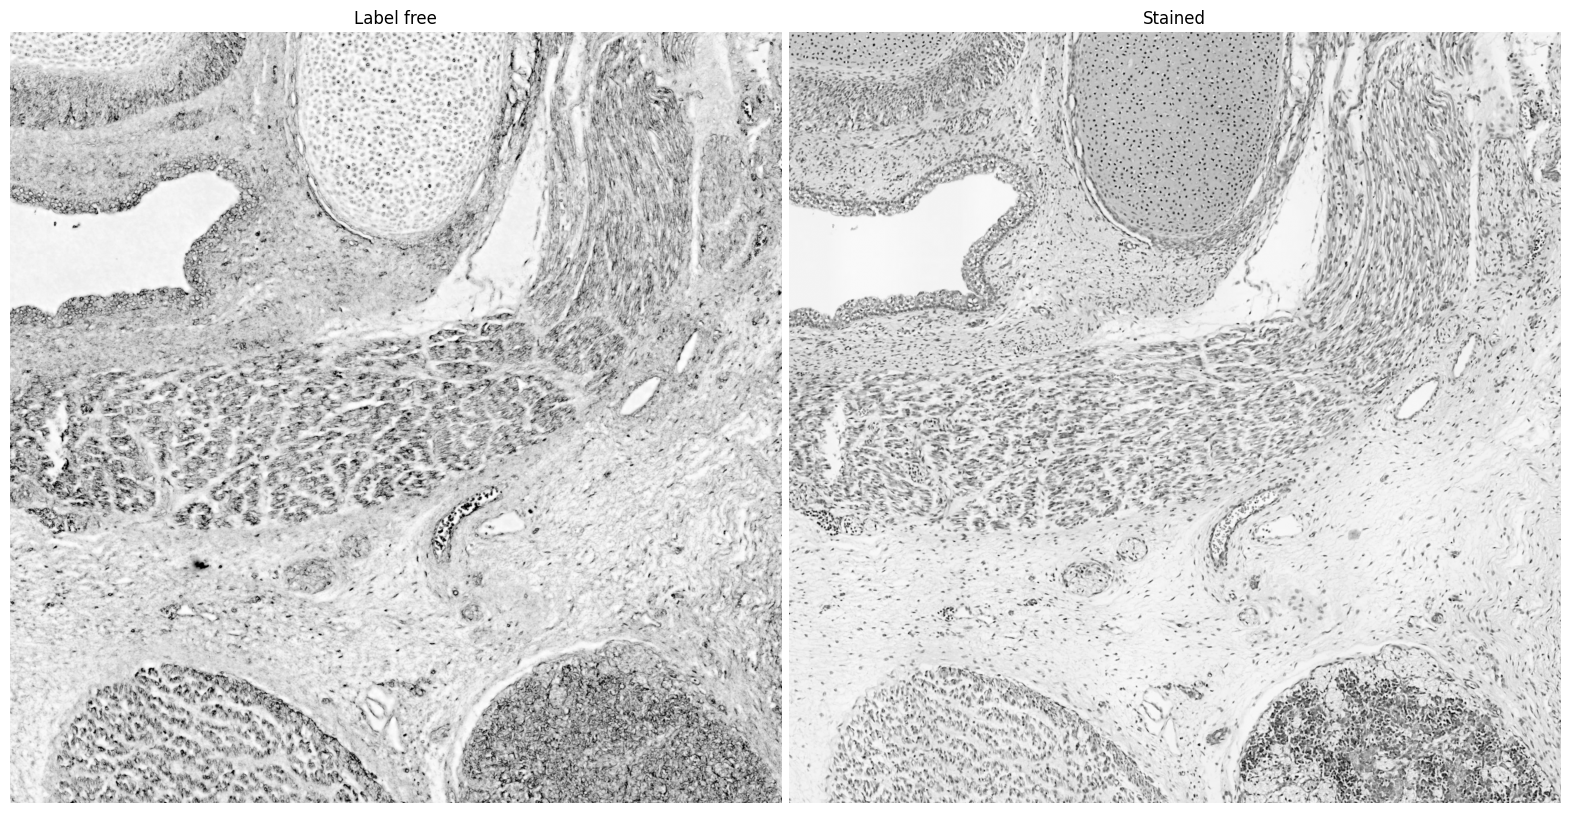

In [49]:
label_free = "../Materiale/Prove/non_colorato.png"
stained_path = "../Materiale/Prove/colorato.png"

if label_free is None or stained_path is None:
    print("Errore: una delle immagini non è stata caricata correttamente.")
    exit()

label_free = cv2.imread(label_free_path, cv2.IMREAD_GRAYSCALE)
stained = cv2.imread(stained_path, cv2.IMREAD_GRAYSCALE)

show_side_images(label_free, 'Label free', stained, 'Stained')

### 3. Normalizzazione (equalizzazione) pre ORB/SIFT
Gli algoritmi per il **_Feature Matching_** (compareremo **SIFT** e **ORB**) cercano dei _keypoints_ in aree di alto contraso, entrambi gli algoritmi dipendono dal contrasto e l'equalizzazione di esso dovrebbe migliorare la distinzione delle caratteristiche.  

**Nota**: _un keypoint è un punto caratteristico di un'immagine che viene identificato dagli algoritmi di feature detection per poter essere confrontato tra immagini diverse. Generalmente essi si trovano in aree con variazioni di intenstità significative (es: angoli, bordi, ...)._  

Come detto in precedenza, dato che i keypoint sono ricercati in zone ad alto contrasto, un istogramma concentrato solo sui neri (destra) o bianchi (sinistra) può risultare problematico.  

---
#### **Passaggio concettuale fondamentale: divisione alignment e applicazione della trasformazione**
Per applicare correttamente la coregistrazione l'idea è di sfruttare algoritmi di feature match come SIFT e ORB, e successivamente applicare l'allineamento globale con ECC. Il problema che sorge è dovuto alla natura di ricerca dei keypoints degli algoritmi sopra citati: essi ricercano i punti caratteristici nelle zone ad alto contrasto, noi però, avendo delle immagini monocromatiche con tantissimi pattern ripetuti e con una bassa variazione di intensità dei pixel otteniamo un istogramma che non si presta al meglio allo scopo.  

Dato che la soluzione a questo scopo è la normalizzazione dell'istogramma, e di conseguenza la modifica delle immagini, dobbiamo applicare una soluzione che consiste nella separazione della fase di _Pre-elaborazione_ e di _Stima geometrica_.  
Creeremo una versione delle immagini processata che useremo per il calcolo delle feature e per la stima dell'omografia; infine applicheremo la trasformazione solo all'immagine originale

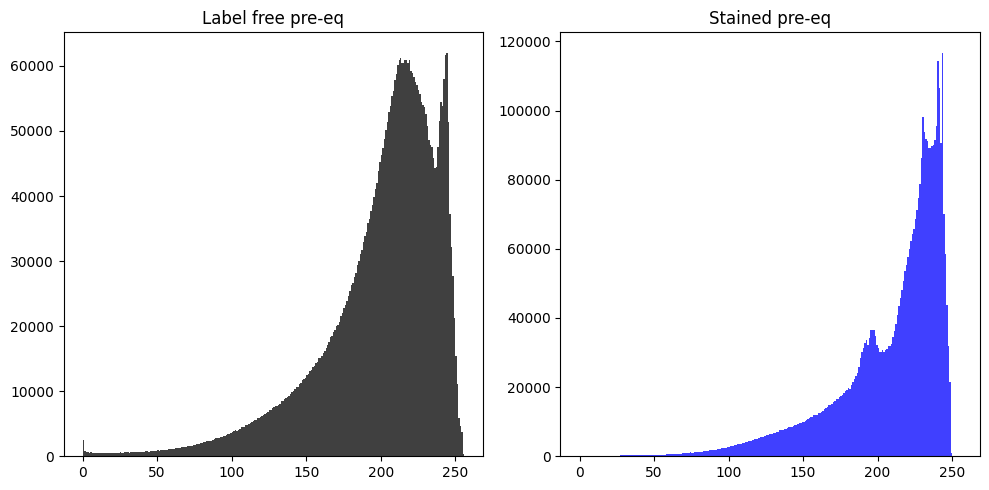

In [ ]:
show_side_hist(label_free, 'Label free pre-eq', stained, 'Stained pre-eq', figsize=(10, 5))

Quello che possiamo fare per migliorare questo istogramma è eseguire una normalizzazione su esso, ma attraverso quale funzione?  
Ci sono venute in mente tre possibili soluzioni che ora metteremo in paragone (ne sceglieremo solo una):
1. `cv2.equalizeHist()`: equalizza il contrasto su tutta l’immagine in modo uniforme;
2. `cv2.normalize()`: non modifica il contrasto, ma scala i valori dei pixel tra due estremi
3. `CLAHE`: Equalizza il contrasto in modo locale, invece che sull'intera immagine

Più precisamente `equalizeHist()` agisce su l'istogramma intero (globale) distribuendo i pixel su tutta la gamma \[0-255\], aumenta drasticamente il contrasto enfatizzando i dettagli, però può amplificare il rumore, cosa indesiderata nel nostro caso.  

`cv2.normalize()` scala tutti i pixel in un intervallo definito, non migliora il contrasto (quindi non ci serve per il feature match) però uniforma le intensità e mantiene i dettagli. Lo useremo per ECC.  

`CLAHE` infine si presenta come versione migliorata di `equalizeHist()`; divide l'immagine in piccole regioni e applica `equalizeHist()`, limita il contrasto con un valore di _clip limit_ per evitare sovra illuminazione. Migliora il contrasto in maniera più controllata e evita distorsioni. Lo useremo per il feature match.

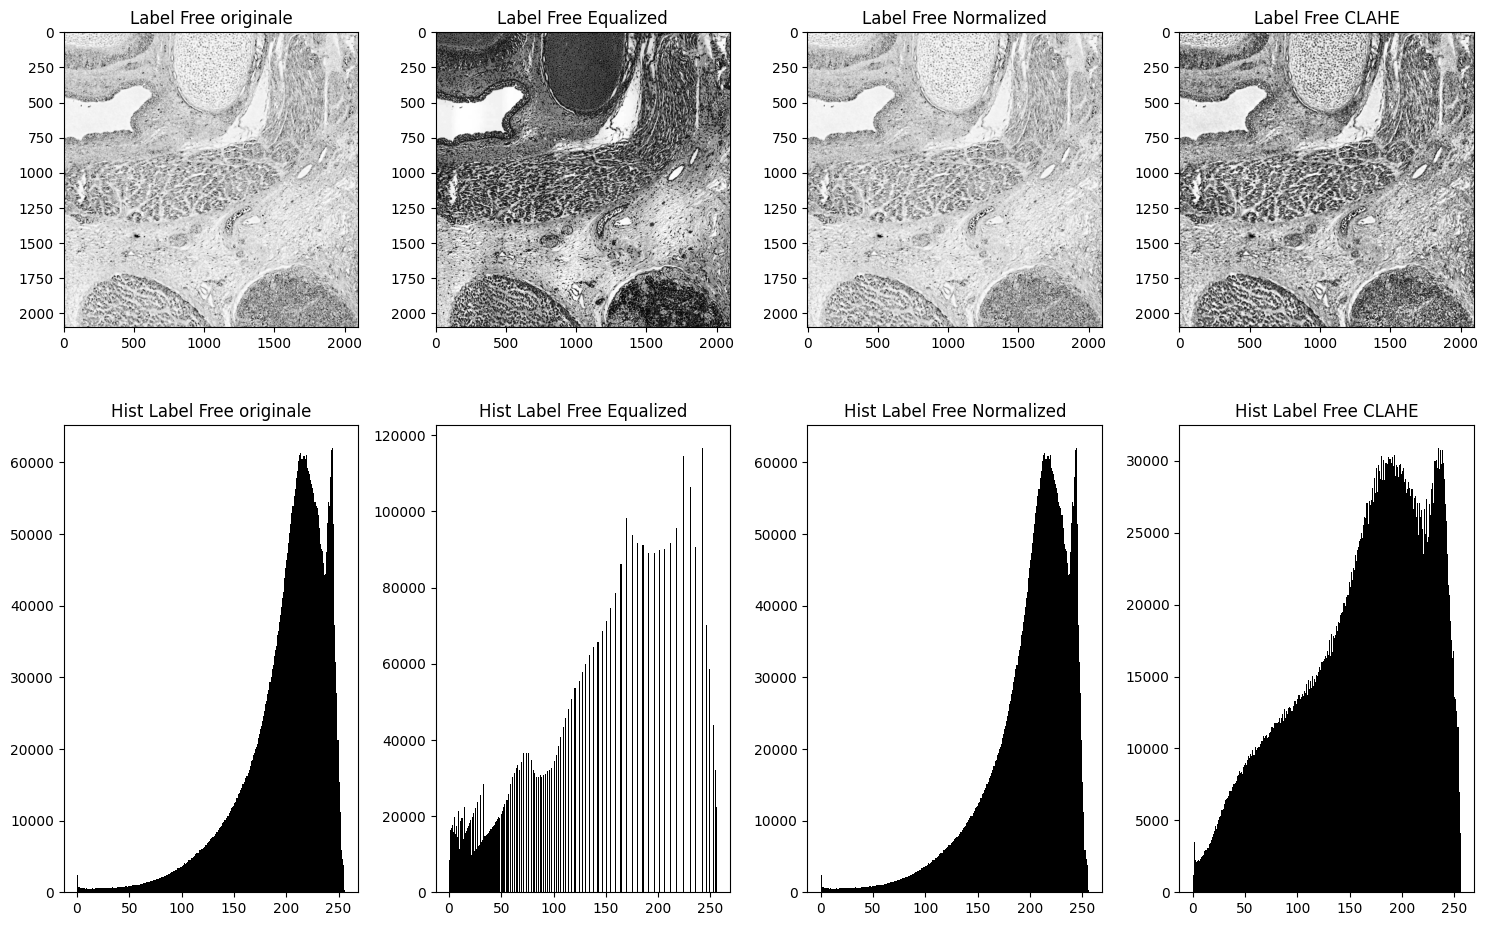

In [37]:
label_free_eq = cv2.equalizeHist(stained)

label_free_norm = cv2.normalize(label_free, None, 0, 255, cv2.NORM_MINMAX)

clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
label_free_clahe = clahe.apply(label_free)

fig1, axes1 = plt.subplots(2, 4, figsize=(15, 10))

# immagini
axes1[0, 0].imshow(label_free, cmap='gray')
axes1[0, 0].set_title("Label Free originale")
axes1[0, 1].imshow(label_free_eq, cmap='gray')
axes1[0, 1].set_title("Label Free Equalized")
axes1[0, 2].imshow(label_free_norm, cmap='gray')
axes1[0, 2].set_title("Label Free Normalized")
axes1[0, 3].imshow(label_free_clahe, cmap='gray')
axes1[0, 3].set_title("Label Free CLAHE")

# istogrammi
axes1[1, 0].hist(label_free.ravel(), bins=256, range=(0, 256), color='black')
axes1[1, 0].set_title("Hist Label Free originale")
axes1[1, 1].hist(label_free_eq.ravel(), bins=256, range=(0, 256), color='black')
axes1[1, 1].set_title("Hist Label Free Equalized")
axes1[1, 2].hist(label_free_norm.ravel(), bins=256, range=(0, 256), color='black')
axes1[1, 2].set_title("Hist Label Free Normalized")
axes1[1, 3].hist(label_free_clahe.ravel(), bins=256, range=(0, 256), color='black')
axes1[1, 3].set_title("Hist Label Free CLAHE")

plt.tight_layout()
plt.show()

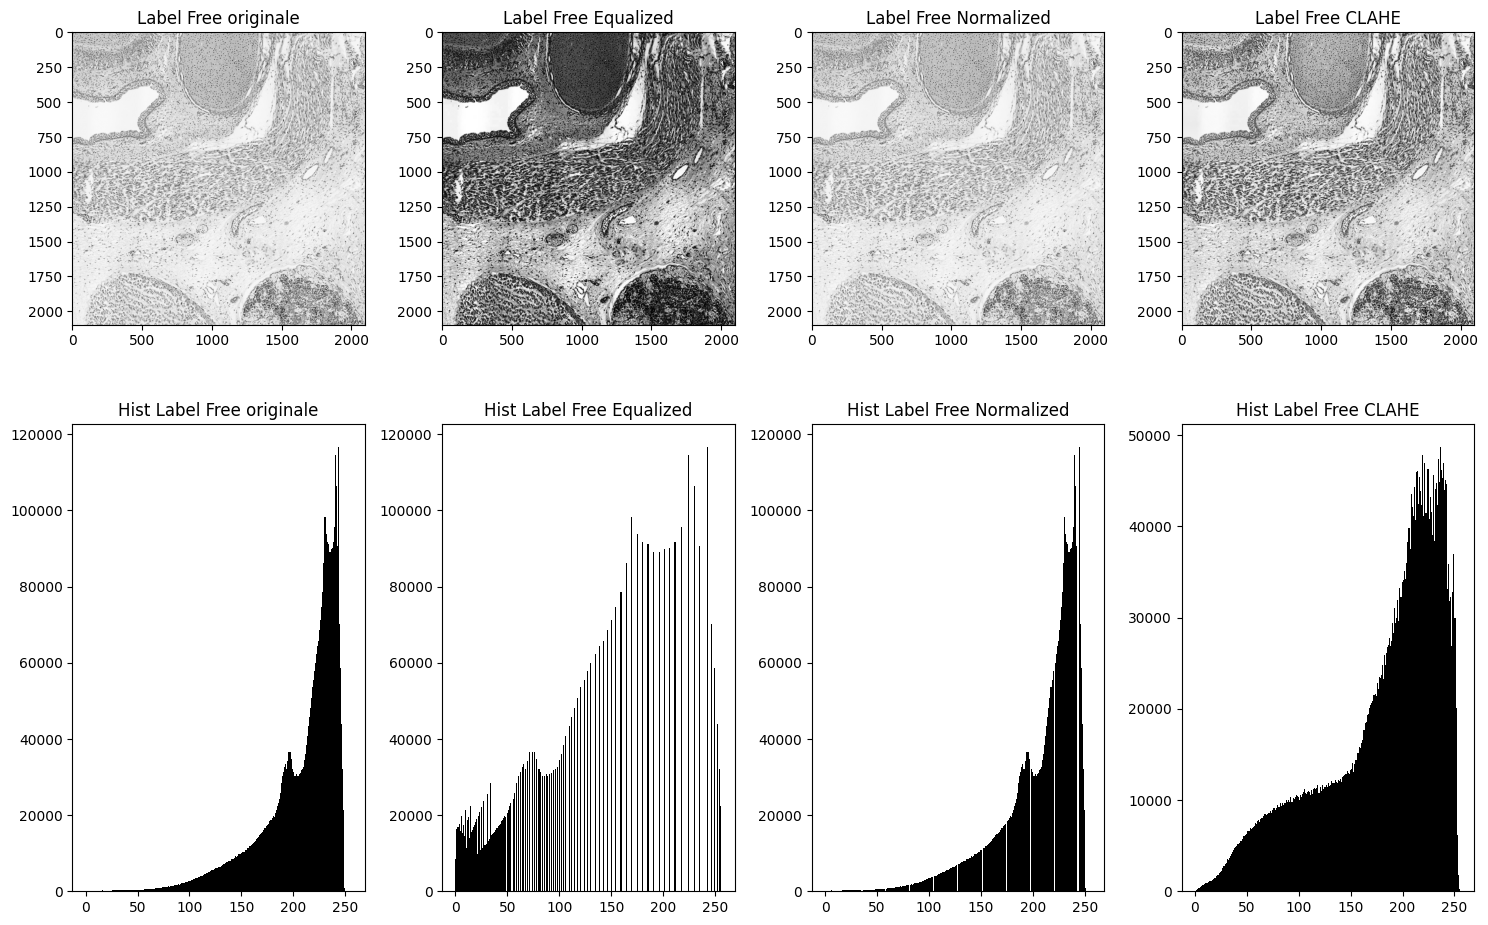

In [36]:
stained_eq = cv2.equalizeHist(stained)

stained_norm = cv2.normalize(stained, None, 0, 255, cv2.NORM_MINMAX)

clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
stained_clahe = clahe.apply(stained)

fig1, axes1 = plt.subplots(2, 4, figsize=(15, 10))

# immagini
axes1[0, 0].imshow(stained, cmap='gray')
axes1[0, 0].set_title("Label Free originale")
axes1[0, 1].imshow(stained_eq, cmap='gray')
axes1[0, 1].set_title("Label Free Equalized")
axes1[0, 2].imshow(stained_norm, cmap='gray')
axes1[0, 2].set_title("Label Free Normalized")
axes1[0, 3].imshow(stained_clahe, cmap='gray')
axes1[0, 3].set_title("Label Free CLAHE")

# istogrammi
axes1[1, 0].hist(stained.ravel(), bins=256, range=(0, 256), color='black')
axes1[1, 0].set_title("Hist Label Free originale")
axes1[1, 1].hist(stained_eq.ravel(), bins=256, range=(0, 256), color='black')
axes1[1, 1].set_title("Hist Label Free Equalized")
axes1[1, 2].hist(stained_norm.ravel(), bins=256, range=(0, 256), color='black')
axes1[1, 2].set_title("Hist Label Free Normalized")
axes1[1, 3].hist(stained_clahe.ravel(), bins=256, range=(0, 256), color='black')
axes1[1, 3].set_title("Hist Label Free CLAHE")

plt.tight_layout()
plt.show()

Ora che abbiamo capito, osservando gli istogrammi, che la normalizzazione migliore per SIFT e ORB è CLAHE possiamo procedere.

---

### 4. Applicare ORB/SIFT
**ORB** e **SIFT** sono i due algoritmi presi in esame al momento, sia per comodità di implementazione che per questioni di brevetti. La differenza principale tra i due è che **ORB** risulta essere più veloce e leggero, ma meno robusto in alcuni casi, mentre **SIFT** esegue un matching più costoso ma con una qualità di matching elevata.  


BFMatcher trova corrispondenze tra feature, mentre RANSAC filtra le corrispondenze errate (useremo sia RANSAC che LO-RANSAC).

In [39]:
NUM_FEATURES = 10000

In [50]:
orb = cv2.ORB_create(nfeatures=NUM_FEATURES)
orb_keypoints_1, orb_descriptors_1 = orb.detectAndCompute(label_free_clahe, None)
orb_keypoints_2, orb_descriptors_1 = orb.detectAndCompute(stained_clahe, None)

if orb_descriptors_1 is None or orb_descriptors_1 is None:
    print("Errore: non sono stati trovati descrittori in una delle immagini.")
    exit()

In [51]:
sift = cv2.SIFT_create(nfeatures=NUM_FEATURES)
sift_keypoints_1, sift_descriptors_1 = sift.detectAndCompute(label_free_clahe, None)
sift_keypoints_2, sift_descriptors_2 = sift.detectAndCompute(stained_clahe, None)

if sift_descriptors_1 is None or sift_descriptors_2 is None:
    print("Errore: non sono stati trovati descrittori in una delle immagini.")
    exit()

Il `None` all'interno di `sift.detectAndCompute(label_free_clahe, None)` e `orb.detectAndCompute(label_free_clahe, None)` indica l'assenza di una maschera. Se si volessero rilevare keypoints solo da una parte specifica dell'immagine, evitando di rilevare keypoints in aree senza informazioni utili (come lo sfondo bianco), possiamo passare una maschera binaria (un array numpy) per assicurarcu che l'algoritmo lavori solo nelle regioni bianche (255) della maschera.  

Noi per questioni di semplicità al momento non inseriamo alcuna maschera, di conseguenza cercheremo di estrarre keypoints da tutta l'immagine 

---
### 5. Matcher
Un matcher è un algoritmo che confronta feature tra due immagini per trovare corrispondenze tra i punti chiave (keypoints). Ora che abbiamo inizializzato i nostri algoritmi di feature matching dobbiamo capire che matcher utilizzare. Ovviamente non c'è una sola strada ma diverse.  
Prenderemo in considerazione due casistiche:
1.  `.match()` con `BFMatcher(<norma>, crossCheck=True)`: soluzione per bilanciare precisione e velocità
2. `.knnMatch` con `BFMatcher(<norma>, crossCheck=False)` e Filtro di Lowe: soluzione per massimizzare la precisione, ovviamente più costosa e lenta  

Come fatto finora opteremo per la soluzione più precisa possibile, nonostante ciò sarà presente anche il codice python per implementare la prima e per comparare i dati ottenuti dai due metodi.

In [55]:
# Applicazione del metodo con crossCheck=True sia per ORB che per SIFT

orb_bf_matcher_match = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
orb_matches = orb_bf_matcher_match.match(orb_descriptors_1, orb_descriptors_2)

sift_bf_matcher_match = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
sift_matches_match = sift_bf_matcher_match.match(sift_descriptors_1, sift_descriptors_2)

In [56]:
# Applicazione del metodo con crossCheck=False sia per ORB che per SIFT
# il filtro di Lowe è riportato più avanti

orb_bf_matcher_knnMatch = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=False)
orb_matches_knnMatch = orb_bf_matcher_knnMatch.knnMatch(orb_descriptors_1, orb_descriptors_2, k=2)

sift_bf_matcher_knnMatch = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)
sift_matches_knnMatch = sift_bf_matcher_knnMatch.knnMatch(sift_descriptors_1, sift_descriptors_2, k=2)